In [22]:
from PIL import Image
import json
import requests
from transformers import AutoProcessor, LlavaForConditionalGeneration
import numpy as np
import torch
import torch.nn.functional as F
import matplotlib.pyplot as plt

In [2]:
#torch.cuda.get_device_properties(0).total_memory

#### Load model

In [3]:
model_name = "llava-hf/llava-1.5-7b-hf"
#model_name = "bczhou/tiny-llava-v1-hf"
#model_name = "unsloth/llava-1.5-7b-hf-bnb-4bit"

# TODO: model_name = "liuhaotian/llava-v1.5-7b"

model =  LlavaForConditionalGeneration.from_pretrained(
    model_name,
    torch_dtype=torch.bfloat16,
    # bug: attention output None with flash_attention_2
    #attn_implementation="flash_attention_2",
    device_map="auto",
)

#model = LlavaForConditionalGeneration.from_pretrained(
    #model_name, 
    #torch_dtype=torch.float16, 
    #low_cpu_mem_usage=True,
    #use_flash_attention_2=True
#).to(0)

#model = LlavaForConditionalGeneration.from_pretrained(
    #model_name,
    #torch_dtype=torch.bfloat16,
    #device_map="cpu",
#)

model.eval()

# load processor
processor = AutoProcessor.from_pretrained(model_name)

Loading checkpoint shards:   0%|          | 0/3 [00:00<?, ?it/s]

#### Load dataset

In [23]:
folder_path = '/root/vlm-compositionality/data/raw/sugarcrepe/'

# add attribute
with open (folder_path+'add_att.json') as f:
    add_attribute = json.load(f)

# add object
with open (folder_path+'add_obj.json') as f:
    add_object = json.load(f)

# replace attribute
with open (folder_path+'replace_att.json') as f:
    replace_attribute = json.load(f)

# replace object
with open (folder_path+'replace_obj.json') as f:
    replace_object = json.load(f)

# replace relation
with open (folder_path+'replace_rel.json') as f:
    replace_relation = json.load(f)

# swap attribute
with open (folder_path+'swap_att.json') as f:
    swap_attribute = json.load(f)

# swap object
with open (folder_path+'swap_obj.json') as f:
    swap_object = json.load(f)

# collate together
dataset = {
    'add_attribute': add_attribute, 'add_object': add_object, 'replace_attribute': replace_attribute,
    'replace_object': replace_object, 'replace_relation': replace_relation,
    'swap_attribute': swap_attribute, 'swap_object': swap_object,
}

#### Image

In [56]:
# wrong : dataset['swap_object']['11']
dataset['swap_object']['13']

{'filename': '000000074200.jpg',
 'caption': 'Three snow boards behind trophies in a window.',
 'negative_caption': 'Three trophies behind snow boards in a window.'}

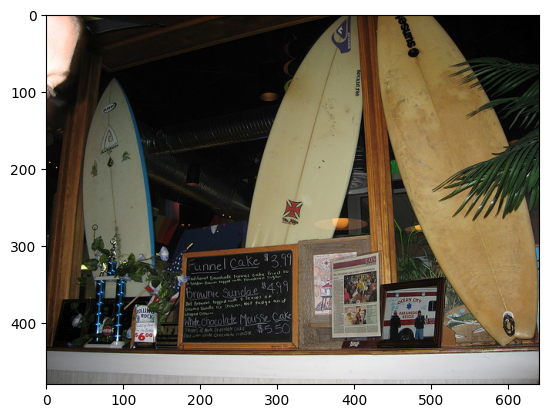

In [58]:
#url = "https://www.ilankelman.org/stopsigns/australia.jpg"
#image = Image.open(requests.get(url, stream=True).raw)

image = Image.open("/root/vlm-compositionality/data/raw/coco_val_2017/000000074200.jpg")
plt.imshow(image)

#### Process image

In [59]:
prompt = "USER: <image>\nChoose the correct caption for the image. Caption 1: Three snow boards behind trophies in a window. Caption 2: Three trophies behind snow boards in a window. ASSISTANT:"
inputs = processor(images=image, text=prompt, return_tensors="pt").to(model.device)

In [60]:
output = model.generate(**inputs, max_new_tokens=200, do_sample=False)
print(processor.decode(output[0][2:], skip_special_tokens=True))

ER:  
Choose the correct caption for the image. Caption 1: Three snow boards behind trophies in a window. Caption 2: Three trophies behind snow boards in a window. ASSISTANT: Caption 1: Three snow boards behind trophies in a window.


#### Forward pass

In [30]:
# 32+1 layers
# each layer hidden_state -> b x seq_len x embed_dim [ignoring b = 1]

# model.vision_tower = CLIPVisionModel
# model.config.vision_feature_layer = -2

# pixel_values : torch.Size([1, 3, 336, 336])
# patch_embeds: torch.Size([1, 1024, 24, 24])
# patch_embeds flattened : torch.Size([1, 576, 1024])
# embeddings : torch.Size([1, 577, 1024])
# hidden_states : torch.Size([1, 577, 1024])
# hidden_states output -2 layer : torch.Size([1, 577, 1024])
# selected_image_feature : torch.Size([1, 577, 1024])
# selected_image_feature : torch.Size([1, 576, 1024])
# image_features : torch.Size([1, 576, 4096])

In [8]:
output = model(**inputs, output_hidden_states=True, output_attentions=True)

In [11]:
len(output['attentions'])

32

In [12]:
# row tokens (queries) attend to column tokens (keys)
output['attentions'][0].shape

torch.Size([1, 32, 593, 593])

In [67]:
token = 'trophies'

processor.tokenizer.encode(token)[1:]

[3147, 561, 583]

In [66]:
processor.tokenizer.decode([3147, 561, 583])

'trophies'

In [73]:
inputs['input_ids'][0] == processor.tokenizer.encode(token)[1:][0]

tensor([False, False, False, False, False, False, False, False, False, False,
        False, False, False, False, False, False, False, False, False, False,
        False, False, False, False, False, False, False, False, False, False,
        False, False, False, False, False, False, False, False, False, False,
        False, False, False, False, False, False, False, False, False, False,
        False, False, False, False, False, False, False, False, False, False,
        False, False, False, False, False, False, False, False, False, False,
        False, False, False, False, False, False, False, False, False, False,
        False, False, False, False, False, False, False, False, False, False,
        False, False, False, False, False, False, False, False, False, False,
        False, False, False, False, False, False, False, False, False, False,
        False, False, False, False, False, False, False, False, False, False,
        False, False, False, False, False, False, False, False, 

In [76]:
# how to find subarray?

False

#### Map embeddings to image patches

In [ ]:
# How to map patch_embeds to pixel_values?

In [82]:
def internal_confidence_heatmap(tokenizer, scores, object):
    class_token_indices = tokenizer.encode(object)[1:]
    if len(class_token_indices) > 1:
        heatmap = 0
        for index in class_token_indices:
            heatmap += scores[:, :, index]
        return heatmap.T
    else:
        return torch.squeeze(scores[:, :, class_token_indices], dim=2).T

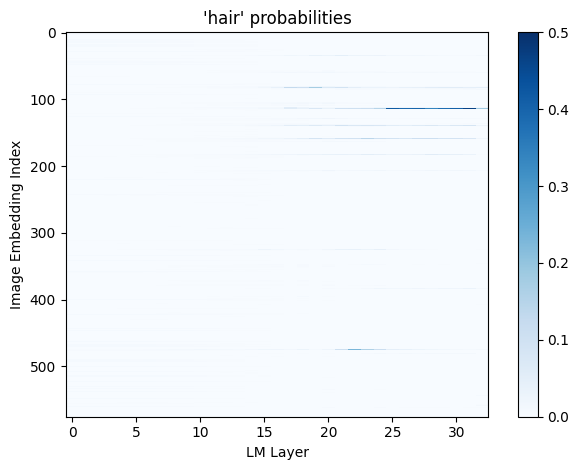

In [89]:
#object = 'tree'
#object = 'car'
#object = 'signs'
#object = 'red'
#object = 'stop'
#object = 'gate'
#object = 'leaves'

# 000000002592.jpg
#object = 'knife'
#object = 'mug'

# 000000008690.jpg
#object = 'goat'
#object = 'girl'
object = 'hair'

heatmap_data = internal_confidence_heatmap(processor.tokenizer, scores, object).detach().cpu().float()
num_image_embeddings = scores.shape[1]
im = plt.imshow(heatmap_data, aspect=30/num_image_embeddings, cmap='Blues', interpolation='nearest')
plt.title(f"'{object}' probabilities")
plt.xlabel("LM Layer")
plt.ylabel("Image Embedding Index")
plt.tight_layout()
plt.clim(0, 0.5)   # 0, 1
plt.colorbar()
plt.show()

In [90]:
def internal_confidence_segmentation(tokenizer, scores, object, num_patches=24):
    class_token_indices = tokenizer.encode(object)[1:]

    if len(class_token_indices) > 1:
        obj_scores = 0
        for index in class_token_indices:
            obj_scores += scores[:, :, index]
    
    else:
        obj_scores = torch.squeeze(scores[:, :, class_token_indices], dim = 2)
        
    max_obj_scores = torch.max(obj_scores, dim=0).values.reshape(num_patches, num_patches).float()
    return max_obj_scores

/tmp/ipykernel_1040/777978903.py:4: DeprecationWarning: BILINEAR is deprecated and will be removed in Pillow 10 (2023-07-01). Use Resampling.BILINEAR instead.
  segmentation_resized = (np.array(Image.fromarray(segmentation.detach().cpu().numpy()).resize((img_width, img_height), Image.BILINEAR)))


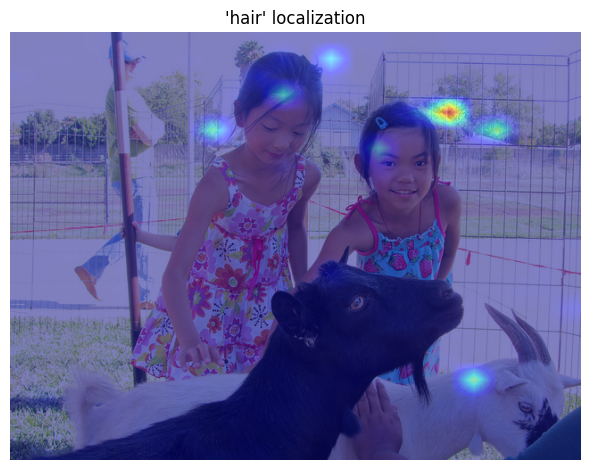

In [91]:
img_width, img_height = image.size

segmentation = internal_confidence_segmentation(processor.tokenizer, scores, object, num_patches=24)
segmentation_resized = (np.array(Image.fromarray(segmentation.detach().cpu().numpy()).resize((img_width, img_height), Image.BILINEAR)))

plt.imshow(image)
plt.imshow(segmentation_resized, cmap='jet', interpolation='bilinear', alpha=0.5)
plt.axis('off')
plt.title(f"'{object}' localization")
plt.tight_layout()
plt.show()